In [8]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import datetime 
from dateutil import parser

import warnings
warnings.filterwarnings("ignore")

os.chdir('/home/jovyan/git/Direct_Avenue_GRP_Project/')
sns.set(rc={'figure.figsize':(11.7,8.27)})

### Load file here

In [9]:
dat = pd.read_csv("cleaned_data.csv")

.

In [10]:
dat = dat.loc[:, 'Access':]

In [11]:
dat

,Access,DMA,Date Aired,Estimate,GRP,Impressions,Length,Market,Media,Spot Cost,Spot Type,Station ID,Time Aired,DOW,daypart
0,30GD,900,2019-02-25,Q119,0.000,0.0,30,Cable,TV,0.0,INV,168,00:05:00,Monday,Late Night
1,30GD,900,2019-02-25,Q119,0.000,0.0,30,National Network,TV,48.0,INV,37,00:05:00,Monday,Late Night
2,30SR,900,2019-02-25,Q119,0.000,0.0,30,Cable,TV,72.0,INV,25,00:05:00,Monday,Late Night
3,30BP,900,2019-02-25,Q119,0.000,0.0,30,Cable,TV,120.0,INV,182,00:08:00,Monday,Late Night
4,30BP,900,2019-02-25,Q119,0.000,0.0,30,Cable,TV,0.0,INV,256,00:10:00,Monday,Late Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683352,30TN,900,2019-01-27,Q119,0.000,NaN,30,Cable,TV,0.0,INV,75,23:50:00,Sunday,Late Fringe
683353,30DP,900,2019-01-27,Q119,0.016,NaN,30,Cable,TV,0.0,INV,161,23:51:00,Sunday,Late Fringe
683354,30TN,900,2019-01-27,Q119,0.000,NaN,30,Cable,TV,0.0,INV,245,23:52:00,Sunday,Late Fringe
683355,30TN,900,2019-01-27,Q119,0.016,NaN,30,Cable,TV,0.0,INV,31,23:53:00,Sunday,Late Fringe


In [12]:
dat.describe()

,GRP,Impressions,Length,Spot Cost,Station ID
count,683357.000000,503839.000000,683357.000000,683357.000000,683357.000000
mean,0.003117,3.445929,29.882916,81.776126,199.088294
std,0.015593,17.950122,1.320057,108.334736,110.998073
min,0.000000,0.000000,15.000000,0.000000,1.000000
25%,0.000000,0.000000,30.000000,48.000000,92.000000
50%,0.000000,0.000000,30.000000,56.000000,219.000000
75%,0.000000,0.000000,30.000000,96.000000,296.000000
max,0.864000,1046.400000,30.000000,5208.000000,379.000000


In [13]:
dat.dtypes

Access          object
DMA             object
Date Aired      object
Estimate        object
GRP            float64
Impressions    float64
Length           int64
Market          object
Media           object
Spot Cost      float64
Spot Type       object
Station ID       int64
Time Aired      object
DOW             object
daypart         object
dtype: object

In [14]:
dat['Date Aired'] = pd.to_datetime(dat['Date Aired'], format='%Y-%m-%d')
dat['Time Aired'] = pd.to_datetime(dat['Time Aired'], format='%H:%M:%S').dt.time

In [15]:
unseen = dat[(dat.Impressions.eq(0.0)) & (dat.GRP.eq(0.0))]
training = dat[dat.GRP > 0.0]

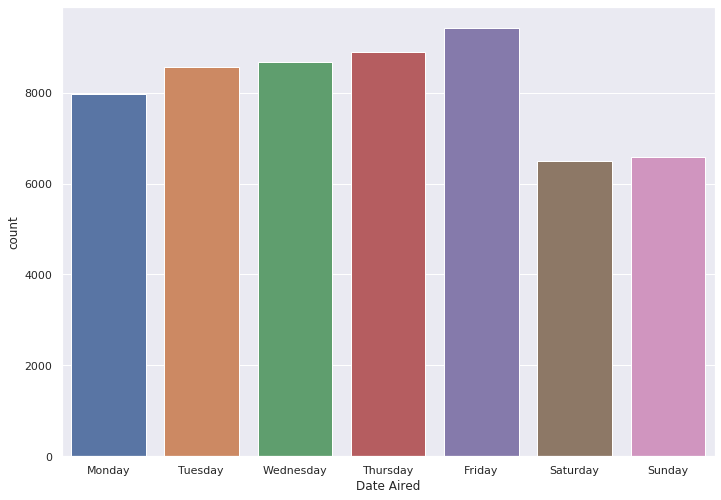

In [16]:
ax = sns.countplot(x=training['Date Aired'].dt.day_name(), data=training)

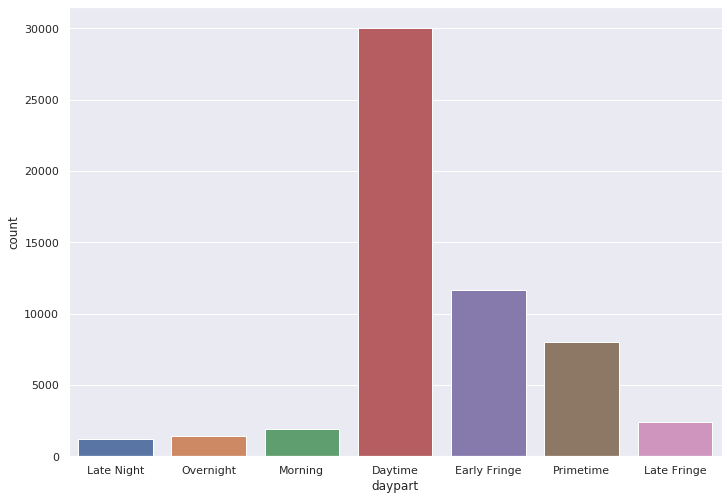

In [222]:
ax = sns.countplot(x=training['daypart'], data=training)

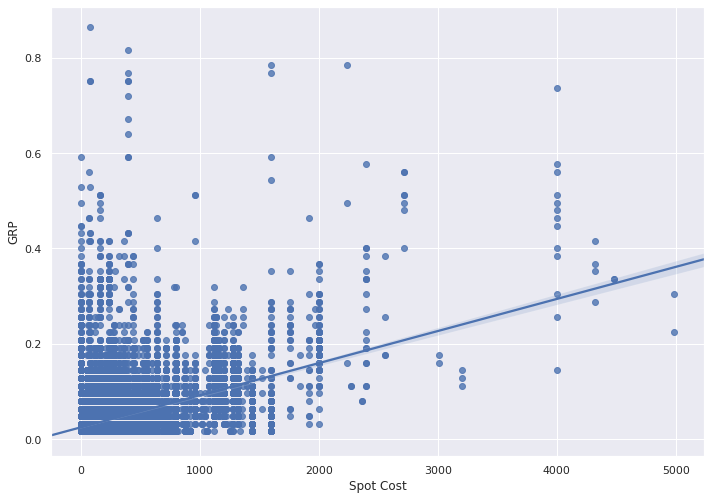

In [228]:
ax = sns.regplot(x=training['Spot Cost'], y=training['GRP'], data=training)

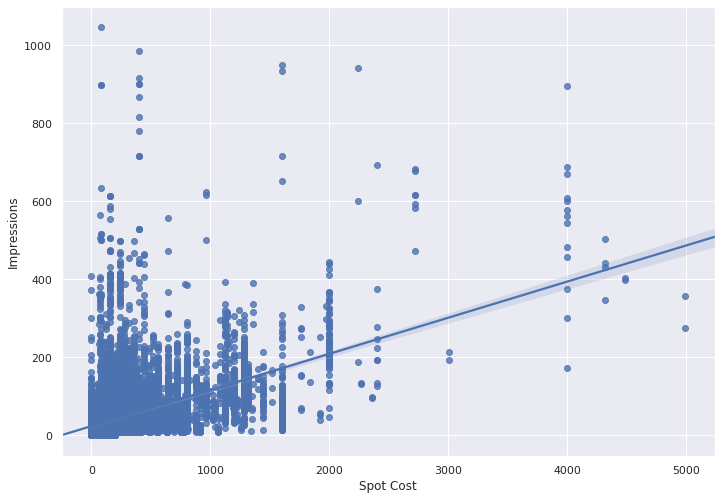

In [230]:
ax = sns.regplot(x=training['Spot Cost'], y=training['Impressions'], data=training)